In [1]:
%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import sys; sys.path.insert(0, "../"); from utils import *
from parametric_discovery_pinn import ParametricPINN
from madgrad import MADGRAD

from pde_diff import TrainSTRidge, FiniteDiff, print_pde
from robust_pde_diff import print_pde, RobustPCA, Robust_LRSTR, DLrSR
from parametric_pde_diff import TrainSGTRidge, create_groups
from pytorch_robust_pca import R_pca

from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time

from pysr import pysr, best

fontsize = 20

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pickle_load("../parametric_pde_data/parametric_burgers.pkl")

x = data['x']; spatial_dims = x.shape[0]
t = data['t']; time_dims = t.shape[0]

Exact = data['u']
X, T = np.meshgrid(x, t)

X_star = np.hstack((to_column_vector(X), to_column_vector(T)))
u_star = to_column_vector(Exact.T)

# domain bounds
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

# Sampling training data points
N = 20000
training_idxs = sampling_from_rows(X_star, N, True)
X_train = X_star[training_idxs, :]
u_train = u_star[training_idxs, :]

# to_tensor
X_star = to_tensor(X_star, True)
u_star = to_tensor(u_star, False)
X_train = to_tensor(X_train, True)
u_train = to_tensor(u_train, False)
lb = to_tensor(lb, False)
ub = to_tensor(ub, False)

u_xx_true = 0.1*np.ones(time_dims)
uu_x_true = -1*(1+0.25*np.sin(t))

Loaded from ../parametric_pde_data/parametric_burgers.pkl


In [3]:
pinn = ParametricPINN(scale=False, lb=lb, ub=ub)
print("Loaded the pretrained weights")
pinn.load_state_dict(torch.load("./saved_path_inverse_parametric_burgers/parametric_pinn.pth"))

Loaded the pretrained weights


<All keys matched successfully>

In [4]:
def pcgrad_closure(return_list=False):
    global N, X_train, u_train
    losses = pinn.loss(*dimension_slicing(X_train), u_train)
    updated_grads = []
    
    for i in range(2):
        optimizer.zero_grad()
        losses[i].backward(retain_graph=True)

        g_task = []
        for param in pinn.parameters():
            if param.grad is not None:
                g_task.append(Variable(param.grad.clone(), requires_grad=False))
            else:
                g_task.append(Variable(torch.zeros(param.shape), requires_grad=False))
        # appending the gradients from each task
        updated_grads.append(g_task)

    updated_grads = list(pcgrad.pc_grad_update(updated_grads))[0]
    for idx, param in enumerate(pinn.parameters()):
        param.grad = (updated_grads[0][idx]+updated_grads[1][idx])
        
    if not return_list: return losses[0]+losses[1]
    else: return losses

In [5]:
def finetuning_closure():
    global N, X_train, u_train
    if torch.is_grad_enabled(): f_opt.zero_grad()
    # the solver network only consider the first N samples.
    mse_loss, pde_loss = pinn.loss(*dimension_slicing(X_train), u_train)
    loss = mse_loss + pde_loss
    if loss.requires_grad: loss.backward(retain_graph=False)
    return loss

#### Finding the eqs

In [6]:
grads_dict = pinn.gradients_dict(*dimension_slicing(X_star))

feature_names = list(grads_dict.keys())
u_t_index = feature_names.index('u_t')

referenced_derivatives = np.hstack([t.detach().numpy() for t in list(grads_dict.values())])
u_t = referenced_derivatives[:, u_t_index:u_t_index+1]

referenced_derivatives = np.delete(referenced_derivatives, u_t_index, 1)
del feature_names[u_t_index]

print(feature_names)

['u', 'u_x', 'u_xx']


#### Two options 
    (1) Cal u_t based on Z (needs differentiable RobustPCA function, more proper)
    (2) Cal u_t based on u (more easy)
    
    ================================================================================
    
    Plan to integrate the AAAI'20 paper

    Robust PCA on u (in matrix form) then flatten&auto diff 
    to calculate u_x, u_xx, and u_t

    Preprocessing

    TrainSGTRidge

    Or DLrSR from robust_pde_diff.py. 
    Use Theta and u_t as the inputs (โค้ดน่าจะไป grouping ให้)

In [7]:
xx, tt = dimension_slicing(X_star)
pred_Exact, _ = pinn(xx, tt)
pred_Exact = pred_Exact.reshape(X.shape)

pred_Exact = to_numpy(pred_Exact)
Z, E1 = RobustPCA(pred_Exact, lam_2=0.1)

# rpca = R_pca(pred_Exact, verbose=True)
# Z, E1 = rpca(max_iter=200, iter_print=100)

Z = to_column_vector(Z)
# Use Z instead
referenced_derivatives[:, 0:1] = Z

Please ensure that the shape of U is correct.
iteration:1, err:688.9721846018407, nc_norm:169.87227557536863 eta1:0.025420781683676837
iteration:50, err:0.0898859218309175, nc_norm:197.34462671541823 eta1:2.7128793115594303
iteration:100, err:0.0009438532014988861, nc_norm:95.0002365382641 eta1:318.46721614364344
iteration:150, err:1.0565240443060347e-05, nc_norm:94.13226844138441 eta1:37385.13811732473
iteration:151, err:9.952827816224932e-06, nc_norm:94.13159347670884 eta1:41123.6519290572


In [8]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
Theta = poly.fit_transform(referenced_derivatives)

poly_feature_names = poly.get_feature_names(feature_names)
for i, f in enumerate(poly_feature_names):
    poly_feature_names[i] = f.replace(" ", "*")

In [9]:
Theta_grouped, Ut_grouped = create_groups(Theta, u_t, spatial_dims, time_dims)

The outputs can be used by the TrainSGTRidge function.


In [10]:
xi, X, E2 = DLrSR(Theta_grouped, u_t.reshape(X.shape))

iteration:1, err:233.0172112734697, nc_norm:84.66840357690613 eta2:0.08173067429843245
iteration:50, err:0.0011774410670416613, nc_norm:45.97405565544931 eta2:619.8207886757111
iteration:93, err:9.327523643357863e-07, nc_norm:45.49029461501378 eta2:1574199.3123620362
IALM Finished at iteration 93


/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_burgers/../parametric_pde_diff.py:602: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/Users/pongpisit/Desktop/Multi-task-Physics-informed-neural-networks/inverse_parametric_burgers/../parametric_pde_diff.py:572: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


In [11]:
# Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
# xi = Xi[np.argmin(Losses)]

In [12]:
poly_feature_names

['u', 'u_x', 'u_xx', 'u*u_x', 'u*u_xx', 'u_x*u_xx']

#### Plotting the results
    - Use DLrSR to detect which terms are useful for predicting the system dynamics.

2 -> u_xx
3 -> u*u_x


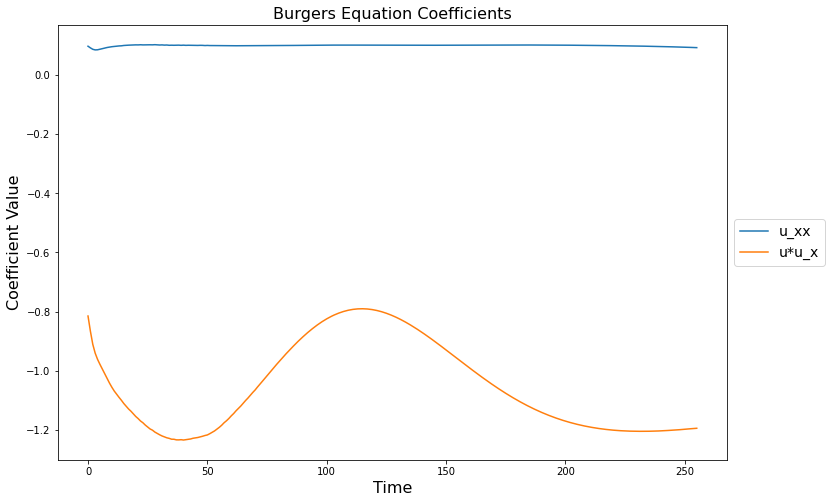

In [13]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, '->', poly_feature_names[j])
        plot(xi[j,:], label = poly_feature_names[j])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)